<a href="https://colab.research.google.com/github/AimjGuytidy/Lockdowns-Impact-on-Air-Quality/blob/main/Model_preparation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
# !pip install TPOT
# !pip install dask==2.20.0 dask-glm==0.2.0 dask-ml==1.0.0
# !pip install tornado==5.0
# !pip install distributed==2.2.0
# !pip install xgboost==0.90

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from numpy import mean
from numpy import std
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.linear_model import LogisticRegression
import plotly.express as px

In [8]:
# from google.colab import drive
# drive.mount('/content/drive')

In [9]:
# path = '/content/drive/MyDrive/Tax_Data/'
# france = pd.read_csv(path + 'france_clean.csv')
france=pd.read_csv('/content/france_clean.csv')
france['Date'] = pd.to_datetime(france['Date'])
france = france.set_index('Date')
france = france[france["City"]=="Paris"]

In [10]:
france

,Country,City,type,co,dew,humidity,no2,o3,pm10,pm25,precipitation,pressure,so2,temperature,wind gust,wind speed,wind-gust,wind-speed
Date,,,,,,,,,,,,,,,,,,
2018-12-31,FR,Paris,0,0.0,8.32,250.91,1247.24,180.46,830.33,2191.79,NaN,3.15,2.02,3.05,NaN,NaN,31.38,3.67
2019-01-01,FR,Paris,0,0.0,8.72,339.40,1086.09,179.52,725.80,1428.40,NaN,4.87,2.60,1.56,NaN,NaN,83.52,15.48
2019-01-02,FR,Paris,0,0.0,4.03,339.38,1073.01,264.86,619.50,1754.79,NaN,20.86,1.16,4.90,NaN,NaN,61.22,16.10
2019-01-03,FR,Paris,0,0.0,1.94,273.61,1219.59,180.11,755.49,1413.78,NaN,76.60,6.39,29.96,NaN,NaN,59.99,81.08
2019-01-04,FR,Paris,0,0.0,3.20,446.48,1014.54,201.94,840.55,1838.20,NaN,118.14,3.05,19.39,NaN,NaN,97.97,150.02
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-11-03,FR,Paris,0,0.0,18.26,742.37,343.06,233.31,283.27,1255.37,NaN,84.39,0.17,20.31,NaN,NaN,33.20,6.82
2021-11-04,FR,Paris,0,0.0,20.75,311.11,493.07,222.24,1197.06,2826.16,NaN,144.27,0.04,24.62,NaN,NaN,65.38,12.63
2021-11-05,FR,Paris,0,0.0,5.27,710.75,462.00,177.90,951.93,848.18,NaN,147.85,0.16,18.83,NaN,NaN,29.51,6.10


# Calculating the AQI
Source: https://www.kaggle.com/rohanrao/calculating-aqi-air-quality-index-tutorial

Source: https://www.researchgate.net/figure/Sub-index-and-breakpoint-pollutant-concentration-for-Indian-Air-Quality-Index_tbl2_281605629

In [11]:
## PM10 Sub-Index calculation
def get_pm10_subindex(x):
    if x <= 50:
        return x
    elif x <= 100:
        return x
    elif x <= 250:
        return 100 + (x - 100) * 100 / 150
    elif x <= 350:
        return 200 + (x - 250)
    elif x <= 430:
        return 300 + (x - 350) * 100 / 80
    elif x > 430:
        return 400 + (x - 430) * 100 / 80
    else:
        return 0

france["pm10_SubIndex"] = france["pm10"].apply(lambda x: get_pm10_subindex(x))

In [12]:
## PM2.5 Sub-Index calculation
def get_pm25_subindex(x):
    if x <= 30:
        return x * 50 / 30
    elif x <= 60:
        return 50 + (x - 30) * 50 / 30
    elif x <= 90:
        return 100 + (x - 60) * 100 / 30
    elif x <= 120:
        return 200 + (x - 90) * 100 / 30
    elif x <= 250:
        return 300 + (x - 120) * 100 / 130
    elif x > 250:
        return 400 + (x - 250) * 100 / 130
    else:
        return 0

france["pm25_SubIndex"] = france["pm25"].apply(lambda x: get_pm25_subindex(x))


In [13]:
## O3 Sub-Index calculation
def get_o3_subindex(x):
    if x <= 40:
        return x * 50 / 40
    elif x <= 80:
        return 50 + (x - 40) * 50 / 40
    elif x <= 380:
        return 100 + (x - 80) * 100 / 300
    elif x <= 800:
        return 200 + (x - 380) * 100 / 420
    elif x <= 1600:
        return 300 + (x - 800) * 100 / 800
    elif x > 1600:
        return 400 + (x - 1600) * 100 / 800
    else:
        return 0

france["o3_SubIndex"] = france["o3"].apply(lambda x: get_o3_subindex(x))

In [14]:
## NO2 Sub-Index calculation
def get_no2_subindex(x):
    if x <= 40:
        return x * 50 / 40
    elif x <= 80:
        return 50 + (x - 40) * 50 / 40
    elif x <= 180:
        return 100 + (x - 80) * 100 / 100
    elif x <= 280:
        return 200 + (x - 180) * 100 / 100
    elif x <= 400:
        return 300 + (x - 280) * 100 / 120
    elif x > 400:
        return 400 + (x - 400) * 100 / 120
    else:
        return 0

france["no2_SubIndex"] = france["no2"].apply(lambda x: get_no2_subindex(x))

In [15]:
## CO Sub-Index calculation
def get_co_subindex(x):
    if x <= 1:
        return x * 50 / 1
    elif x <= 2:
        return 50 + (x - 1) * 50 / 1
    elif x <= 10:
        return 100 + (x - 2) * 100 / 8
    elif x <= 17:
        return 200 + (x - 10) * 100 / 7
    elif x <= 34:
        return 300 + (x - 17) * 100 / 17
    elif x > 34:
        return 400 + (x - 34) * 100 / 17
    else:
        return 0

france["co_SubIndex"] = france["co"].apply(lambda x: get_co_subindex(x))

In [16]:
france

,Country,City,type,co,dew,humidity,no2,o3,pm10,pm25,precipitation,pressure,so2,temperature,wind gust,wind speed,wind-gust,wind-speed,pm10_SubIndex,pm25_SubIndex,o3_SubIndex,no2_SubIndex,co_SubIndex
Date,,,,,,,,,,,,,,,,,,,,,,,
2018-12-31,FR,Paris,0,0.0,8.32,250.91,1247.24,180.46,830.33,2191.79,NaN,3.15,2.02,3.05,NaN,NaN,31.38,3.67,900.4125,1893.684615,133.486667,1106.033333,0.0
2019-01-01,FR,Paris,0,0.0,8.72,339.40,1086.09,179.52,725.80,1428.40,NaN,4.87,2.60,1.56,NaN,NaN,83.52,15.48,769.7500,1306.461538,133.173333,971.741667,0.0
2019-01-02,FR,Paris,0,0.0,4.03,339.38,1073.01,264.86,619.50,1754.79,NaN,20.86,1.16,4.90,NaN,NaN,61.22,16.10,636.8750,1557.530769,161.620000,960.841667,0.0
2019-01-03,FR,Paris,0,0.0,1.94,273.61,1219.59,180.11,755.49,1413.78,NaN,76.60,6.39,29.96,NaN,NaN,59.99,81.08,806.8625,1295.215385,133.370000,1082.991667,0.0
2019-01-04,FR,Paris,0,0.0,3.20,446.48,1014.54,201.94,840.55,1838.20,NaN,118.14,3.05,19.39,NaN,NaN,97.97,150.02,913.1875,1621.692308,140.646667,912.116667,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-11-03,FR,Paris,0,0.0,18.26,742.37,343.06,233.31,283.27,1255.37,NaN,84.39,0.17,20.31,NaN,NaN,33.20,6.82,233.2700,1173.361538,151.103333,352.550000,0.0
2021-11-04,FR,Paris,0,0.0,20.75,311.11,493.07,222.24,1197.06,2826.16,NaN,144.27,0.04,24.62,NaN,NaN,65.38,12.63,1358.8250,2381.661538,147.413333,477.558333,0.0
2021-11-05,FR,Paris,0,0.0,5.27,710.75,462.00,177.90,951.93,848.18,NaN,147.85,0.16,18.83,NaN,NaN,29.51,6.10,1052.4125,860.138462,132.633333,451.666667,0.0


In [17]:
france = france[["pm10_SubIndex","pm25_SubIndex","o3_SubIndex","no2_SubIndex","co_SubIndex","type"]]
france.head()

,pm10_SubIndex,pm25_SubIndex,o3_SubIndex,no2_SubIndex,co_SubIndex,type
Date,,,,,,
2018-12-31,900.4125,1893.684615,133.486667,1106.033333,0.0,0
2019-01-01,769.7500,1306.461538,133.173333,971.741667,0.0,0
2019-01-02,636.8750,1557.530769,161.620000,960.841667,0.0,0
2019-01-03,806.8625,1295.215385,133.370000,1082.991667,0.0,0
2019-01-04,913.1875,1621.692308,140.646667,912.116667,0.0,0


In [18]:
## AQI bucketing
def get_AQI_bucket(x):
    if x <= 50:
        return "Good"
    elif x <= 100:
        return "Satisfactory"
    elif x <= 200:
        return "Moderate"
    elif x <= 300:
        return "Poor"
    elif x <= 400:
        return "Very Poor"
    elif x > 400:
        return "Severe"
    else:
        return np.NaN
        

In [19]:
france0 = france.copy()
france0.loc[:,"Checks"] = (france["pm10_SubIndex"] > 0).astype(int) + \
                (france["pm25_SubIndex"] > 0).astype(int) + \
                (france["o3_SubIndex"] > 0).astype(int) + \
                (france["no2_SubIndex"] > 0).astype(int) + \
                (france["co_SubIndex"] > 0).astype(int) 

In [20]:
france0["AQI_calculated"] = round(france0[["pm10_SubIndex", "pm25_SubIndex", "o3_SubIndex", "no2_SubIndex",
                                 "co_SubIndex"]].max(axis = 1))

In [21]:
france0.loc[france["pm25_SubIndex"] + france0["pm10_SubIndex"] <= 0, "AQI_calculated"] = np.NaN
france0.loc[france0.Checks < 3, "AQI_calculated"] = np.NaN

In [22]:
france0["AQI_Class"] = france0["AQI_calculated"].apply(lambda x: get_AQI_bucket(x))
france0[~france0.AQI_calculated.isna()].head(13)

,pm10_SubIndex,pm25_SubIndex,o3_SubIndex,no2_SubIndex,co_SubIndex,type,Checks,AQI_calculated,AQI_Class
Date,,,,,,,,,
2018-12-31,900.4125,1893.684615,133.486667,1106.033333,0.0,0,4,1894.0,Severe
2019-01-01,769.7500,1306.461538,133.173333,971.741667,0.0,0,4,1306.0,Severe
2019-01-02,636.8750,1557.530769,161.620000,960.841667,0.0,0,4,1558.0,Severe
2019-01-03,806.8625,1295.215385,133.370000,1082.991667,0.0,0,4,1295.0,Severe
2019-01-04,913.1875,1621.692308,140.646667,912.116667,0.0,0,4,1622.0,Severe
2019-01-05,766.0125,1174.807692,125.486667,684.991667,0.0,0,4,1175.0,Severe
2019-01-06,805.3875,1685.069231,128.633333,1059.250000,0.0,0,4,1685.0,Severe
2019-01-07,1168.7750,2179.853846,112.266667,972.225000,0.0,0,4,2180.0,Severe
2019-01-08,1052.0625,1507.515385,154.670000,1030.066667,0.0,0,4,1508.0,Severe


In [23]:
france0.AQI_Class.value_counts()

Severe    1017
Name: AQI_Class, dtype: int64

# Model building

Source: https://www.kaggle.com/anbarivan/indian-air-quality-analysis-prediction-using-ml

In [24]:
# france0[["AQI_calculated"]].sort_values(by='Date',ascending=False)
# france0[["AQI_calculated"]].plot(figsize=(15, 6))
# plt.show()
df = france0[~france0.AQI_calculated.isna()]
fig = px.scatter(data_frame=df,x=df.index,y='AQI_calculated',color='type',symbol='AQI_Class',log_y=True)
fig.show()
# y=france0[["AQI_calculated"]].AQI_calculated

In [25]:
france0 = france0.drop(['Checks'],axis=1)

In [26]:
france0.AQI_Class.value_counts()

Severe    1017
Name: AQI_Class, dtype: int64

In [27]:
france0['AQI_Class'] = france0['AQI_Class'].map({'Good': 5, 'Satisfactory': 4, 'Moderate': 3, 'Poor': 2,'Very Poor': 1, 'Severe': 0})

In [28]:
france_uni_var = france0[["AQI_calculated"]]
# france_uni_var

In [29]:
france0 = france0.dropna()

In [30]:
france0.head()

,pm10_SubIndex,pm25_SubIndex,o3_SubIndex,no2_SubIndex,co_SubIndex,type,AQI_calculated,AQI_Class
Date,,,,,,,,
2018-12-31,900.4125,1893.684615,133.486667,1106.033333,0.0,0,1894.0,0
2019-01-01,769.7500,1306.461538,133.173333,971.741667,0.0,0,1306.0,0
2019-01-02,636.8750,1557.530769,161.620000,960.841667,0.0,0,1558.0,0
2019-01-03,806.8625,1295.215385,133.370000,1082.991667,0.0,0,1295.0,0
2019-01-04,913.1875,1621.692308,140.646667,912.116667,0.0,0,1622.0,0


In [34]:
france0[france0['type'] == 1]['type'].idxmin()

Timestamp('2021-03-19 00:00:00')

In [37]:
france0[france0['type'] == 1]['type']

Date
2021-03-19    1
2021-03-20    1
2021-03-21    1
2021-03-22    1
2021-03-23    1
2021-03-24    1
2021-03-25    1
2021-03-26    1
2021-03-27    1
2021-03-28    1
2021-03-29    1
2021-03-30    1
2021-03-31    1
2021-04-01    1
2021-04-02    1
2021-04-03    1
2021-04-04    1
2021-04-05    1
2021-04-06    1
2021-04-07    1
2021-04-08    1
2021-04-09    1
2021-04-10    1
2021-04-11    1
2021-04-12    1
2021-04-13    1
2021-04-14    1
2021-04-15    1
2021-04-16    1
2021-04-17    1
2021-04-18    1
Name: type, dtype: int64

In [35]:
france0[france0['type'] == 2]['type'].idxmin()

Timestamp('2020-03-17 00:00:00')

In [42]:
pd.set_option('display.max_rows',150)
end_date = "2020-12-31"
france0[(france0['type'] == 2)&(france0.index<=end_date)]['type'].to_frame()

,type
Date,
2020-03-17,2
2020-03-18,2
2020-03-19,2
2020-03-20,2
2020-03-21,2
2020-03-22,2
2020-03-23,2
2020-03-24,2
2020-03-25,2


In [ ]:
train_len = 800
train = france_uni_var[0:train_len] 
test = france_uni_var[train_len:] 

In [ ]:
y_hat_naive = test.copy()
y_hat_naive['naive_forecast'] = train['AQI_calculated'][train_len-1]

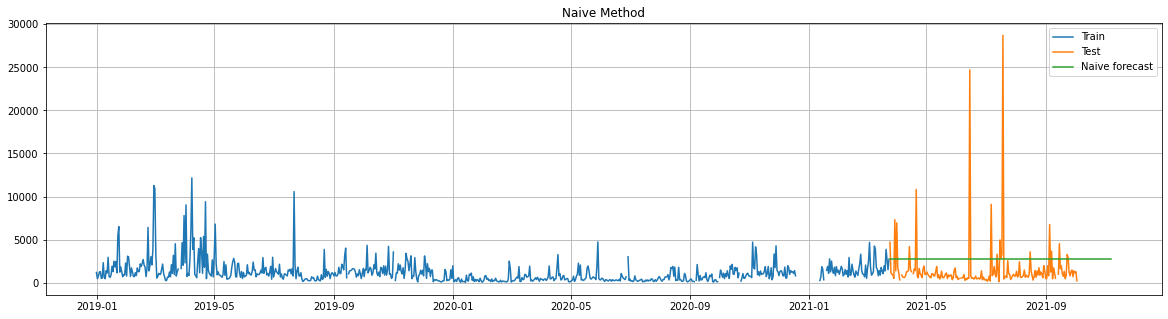

In [ ]:
plt.figure(figsize=(20,5))
plt.grid()
plt.plot(train['AQI_calculated'], label='Train')
plt.plot(test['AQI_calculated'], label='Test')
plt.plot(y_hat_naive['naive_forecast'], label='Naive forecast')
plt.legend(loc='best')
plt.title('Naive Method')
plt.show()

# From the above plot, we can see that the naive bayes classifier for timeseries is not performing at all, thus we have to resolt to using other classifier and see if which performs better.

In [ ]:
from sklearn.model_selection import train_test_split
feature_cols = ['pm10_SubIndex',	'pm25_SubIndex', 'o3_SubIndex',	'no2_SubIndex',	'co_SubIndex',	'type']
X = france[feature_cols].values # Features
y = france.AQI_Class.values # Target variable
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, shuffle=False, random_state=42)
print('The number of training samples: {}\nThe number of testing samples: {}'.format(X_train.shape[0], X_test.shape[0]))

The number of training samples: 679
The number of testing samples: 291


# Using TPOT(recommended by Mustapha), we evaluate many different classifiers and it will show us which is the best classifier

In [ ]:
from tpot import TPOTClassifier
pipeline_optimizer = TPOTClassifier()
pipeline_optimizer = TPOTClassifier(generations=5, population_size=20, cv=5,
                                    random_state=42, verbosity=2)

In [ ]:
pipeline_optimizer.fit(X_train, y_train)

Optimization Progress:   0%|          | 0/120 [00:00<?, ?pipeline/s]


Generation 1 - Current best internal CV score: 0.9573202614379085

Generation 2 - Current best internal CV score: 0.9602723311546841

Generation 3 - Current best internal CV score: 0.9617211328976033

Generation 4 - Current best internal CV score: 0.9617211328976033

Generation 5 - Current best internal CV score: 0.9661546840958606

Best pipeline: DecisionTreeClassifier(RobustScaler(DecisionTreeClassifier(MLPClassifier(input_matrix, alpha=0.1, learning_rate_init=1.0), criterion=entropy, max_depth=6, min_samples_leaf=18, min_samples_split=19)), criterion=gini, max_depth=7, min_samples_leaf=5, min_samples_split=12)


TPOTClassifier(generations=5, population_size=20, random_state=42, verbosity=2)

TPOT's best classifier Testing

In [ ]:

print(pipeline_optimizer.score(X_test, y_test))

0.9587628865979382


In [ ]:
pipeline_optimizer.export('tpot_exported_pipeline.py')
from google.colab import files
files.download( "tpot_exported_pipeline.py" )

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Looking at the accuracy, it looks as if the decision tree classifier from TPOT, is accurate enough to be used, although this model need daily polutant related data to classify that day's AQI_class.  could we be able to have model capable of predicting the AQI without needing to know the polutant's values, that would very good

The next step will be to scale this model to more than one city and country